# Multiple Linear Regression of Cryptocurrency

The following model I have developed to demonstrate how to extract, transform and load data and build a pipeline based on a Multiple Regression problem. I aim to forecast Bitcoin (C$) prices by extrapolating historical data, training, validating and testing the model before evaluating its accuracy using a benchmark score.

I am looking to predict the closing price (dependent variable) based on its relationship with other intraday price and volume information (independent variables).

## Performance Measure Selection
For the purpose of a multiple regression I am selecting the Root Mean Square Error (RMSE) to measure the overall degree of error when making model my predictions. 

$$ RMSE(X,h) = \sqrt {\frac{1}{m} \sum_{i=1}^{m}(h(x^ {i})-y^ {i})^2} $$

In [1]:
import pandas as pd
import numpy as np
import os
import tarfile
import urllib3

DOWNLOAD_URL = "https://ca.finance.yahoo.com/quote/BTC-CAD/history?p=BTC-CAD"
BITCOIN_PATH = os.path.join("C:/Users/lynst/Documents/GitHub/machine-learning-projects/machine-learning/BTC_CAD.csv")
BITCOIN_URL = DOWNLOAD_URL + "C:/Users/lynst/Documents/GitHub/machine-learning-projects/machine-learning/BTC_CAD.csv"

The uniform resource locater for the downloaded dataset can be changed according to any Ticker symbol listed in Yahoo Finance. The path to extract the data to can be stored in a separate variable which can then be joined to the download URL and stored in yet another container. This just makes it a little easier to reference an object for compression-decompression 'tarfiles' which may save processing time and reduce latency.

In [2]:
def fetch_bitcoin_data(bitcoin_url=BITCOIN_URL, bitcoin_path=BITCOIN_PATH):
    os.makedirs(bitcoin_path, exist_ok=True)
    tgz_path = os.path.join(bitcoin_path)
    urllib3.request.urlretrieve(bitcoin_url, tgz_path)
    bitcoin_tgz = tarfile.open(tgz_path)
    bitcoin_tgz.extract_all(path=bitcoin_path)
    bitcoin_tgz.close()
    
def load_bitcoin_data(bitcoin_path=BITCOIN_PATH):
    csv_path = os.path.join(bitcoin_path)
    return pd.read_csv(csv_path)

This works for large files which need compressing but an easier alternative for smaller file sizes (maybe less than 10,000 entries) would be to read the dataset URL and then store it as a dataframe variable using Pandas:

In [3]:
'''
# import data
bitcoin_path = "https://ca.finance.yahoo.com/quote/BTC-CAD/history?p=BTC-CAD"

# read data into csv chosen format
bitcoin = pd.read_csv("C:/Users/lynst/Documents/GitHub/machine-learning-projects/machine-learning/BTC_CAD.csv")

#load data into dataframe
df = pd.DataFrame(bitcoin).dropna(axis=0)
'''

'\n# import data\nbitcoin_path = "https://ca.finance.yahoo.com/quote/BTC-CAD/history?p=BTC-CAD"\n\n# read data into csv chosen format\nbitcoin = pd.read_csv("C:/Users/lynst/Documents/GitHub/machine-learning-projects/machine-learning/BTC_CAD.csv")\n\n#load data into dataframe\ndf = pd.DataFrame(bitcoin).dropna(axis=0)\n'

Start by loading the Canadian denominated Bitcoin data below.

In [4]:
btc_cad = load_bitcoin_data()

Each column represents a different feature, for example 'High', 'Low' and 'Close' prices are all features. These features are also known as attributes, input, or predictor variables which can be used to ascertain a stock price prediction (called labels, output, or target variables).

In [5]:
# get stock info
print(btc_cad.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 366 entries, 0 to 365
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       366 non-null    object 
 1   Open       362 non-null    float64
 2   High       362 non-null    float64
 3   Low        362 non-null    float64
 4   Close      362 non-null    float64
 5   Adj Close  362 non-null    float64
 6   Volume     362 non-null    float64
dtypes: float64(6), object(1)
memory usage: 20.1+ KB
None


The following method gives a breakdown of the first and last entries in the dataset.

In [6]:
btc_cad.info

<bound method DataFrame.info of            Date      Open      High       Low     Close  Adj Close  \
0    2020-04-21   9718.07   9838.33   9728.25   9763.94    9763.94   
1    2020-04-22   9762.68  10125.87   9747.39  10096.28   10096.28   
2    2020-04-23  10102.09  10533.73  10009.76  10451.16   10451.16   
3    2020-04-24  10457.43  10678.71  10457.43  10642.81   10642.81   
4    2020-04-25  10642.22  10773.18  10601.61  10669.64   10669.64   
..          ...       ...       ...       ...       ...        ...   
361  2021-04-17  76964.70  78268.41  75503.00  75906.36   75906.36   
362  2021-04-18  75928.95  76373.72  66081.83  70374.91   70374.91   
363  2021-04-19  70344.11  71803.61  68107.27  69788.23   69788.23   
364  2021-04-20       NaN       NaN       NaN       NaN        NaN   
365  2021-04-21  71509.30  71556.76  71132.08  71477.76   71477.76   

           Volume  
0    4.624843e+10  
1    4.716635e+10  
2    6.119120e+10  
3    4.881932e+10  
4    4.643028e+10  
..     

## Data Preprocessing
### Overall Statistics
Using the describe() method to view summary statistics helps define the average values or range of data involved in this dataset, as well as a measure of dispersion about its mean.

In [7]:
btc_cad.describe()

,Open,High,Low,Close,Adj Close,Volume
count,362.000000,362.000000,362.000000,362.000000,362.000000,3.620000e+02
mean,29707.219227,30555.675387,28874.214006,29864.750829,29864.750829,5.364938e+10
std,21773.553828,22482.286402,20992.768212,21845.825531,21845.825531,3.297456e+10
min,9718.070000,9838.330000,9728.250000,9763.940000,9763.940000,1.663903e+10
25%,13373.917500,13684.485000,13056.075000,13421.037500,13421.037500,3.142625e+10
50%,16520.155000,17169.830000,16253.260000,16921.560000,16921.560000,4.716901e+10
75%,44679.117500,46686.912500,41998.325000,45279.530000,45279.530000,6.929678e+10
max,79623.850000,81445.670000,77726.050000,79598.410000,79598.410000,4.470000e+11


So I can tell the average closing price is C$29,865 to the nearest integer. 

There isn't much data to work from (one years worth exactly), but I would like to create a dataframe object from the price data and try and use it to forecast future price information. Taking a look at which columns are present in the dataset gives me:

In [8]:
btc_cad.columns

Index(['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'], dtype='object')

And now lets see the first and last 5 entries in the table:

In [9]:
btc_cad.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2020-04-21,9718.07,9838.33,9728.25,9763.94,9763.94,4.624843e+10
1,2020-04-22,9762.68,10125.87,9747.39,10096.28,10096.28,4.716635e+10
2,2020-04-23,10102.09,10533.73,10009.76,10451.16,10451.16,6.119120e+10
3,2020-04-24,10457.43,10678.71,10457.43,10642.81,10642.81,4.881932e+10
4,2020-04-25,10642.22,10773.18,10601.61,10669.64,10669.64,4.643028e+10


And now the tail of the dataframe.

In [10]:
btc_cad.tail()

,Date,Open,High,Low,Close,Adj Close,Volume
361,2021-04-17,76964.70,78268.41,75503.00,75906.36,75906.36,8.272967e+10
362,2021-04-18,75928.95,76373.72,66081.83,70374.91,70374.91,1.220000e+11
363,2021-04-19,70344.11,71803.61,68107.27,69788.23,69788.23,8.183693e+10
364,2021-04-20,NaN,NaN,NaN,NaN,NaN,NaN
365,2021-04-21,71509.30,71556.76,71132.08,71477.76,71477.76,8.495634e+10


## Cleaning the Data
A brief look at the summary info for the dataset tells me there are a different number of date values compared to the rest of the column entries. This will need to be addressed, followed by any missing values, NaN, 'isnull' or entries with 'zero'. I can also see the different number 'count' for entries using the count() method:

In [11]:
btc_cad.count()

Date         366
Open         362
High         362
Low          362
Close        362
Adj Close    362
Volume       362
dtype: int64

First I just want to see what shape the dataframe is.

In [12]:
btc_cad.shape

(366, 7)

So it's 366 rows by 7 columns or a (366x7) matrix. Next, to find the total number of missing entries.

In [13]:
bitcoin_missing_values_count = btc_cad.isnull().sum()
bitcoin_missing_values_count[0:7]

Date         0
Open         4
High         4
Low          4
Close        4
Adj Close    4
Volume       4
dtype: int64

Further examination allows me to calculate the total number of rows containing missing data points as a percentage of the total number of rows in the dataframe.

In [14]:
total_bitcoin = np.product(btc_cad.shape)
total_missing_bitcoin = bitcoin_missing_values_count.sum()

percent_missing_values = (total_missing_bitcoin/total_bitcoin) * 100
print(percent_missing_values)

0.936768149882904


From this I can see that just under 1% of the total values are missing. I can either choose to leave them out completely (as they may not really affect my model for the purpose of this exercise) or use imputed values such as the mean or median.

### Removing Rows
Having checked the csv file I can determine that there is no real reason for the missing values (null entries) for these dates. At first I thought these missing values might be due to public holidays but because Bitcoin is a currency, it appears to be traded OTC (Over The Counter) beyong normal trading hours throughout the day, seven days a week. As a result I have chosen to leave these missing values out using the dropna() method to eliminate them. This should provide a total of 162 rows.

In [15]:
# dropping the rows with missing or 'na' entries using 'axis=0' for the row dimension
btc_cad = btc_cad.dropna(axis=0)

# finding the new row count
btc_cad.count()

Date         362
Open         362
High         362
Low          362
Close        362
Adj Close    362
Volume       362
dtype: int64

This time there are exactly 362 rows for each column. It's important to set the argument (axis=0) otherwise dropping the values doesn't work. 

### Removing Columns (Feature Selection)

The values in the 'Adj Close' column are exactly the same as in the 'Close' column so I will remove 'Adj Close' completely from the dataset in an attempt to regularize the model. This is unecessary data which can be removed as it could contribute to bias and bleed into the test data. It's better to reduce the overall number of variables particularly removing those which are not relevant (the process of regularization to simplify the model and avoid overfitting).

In [16]:
btc_cad.columns

Index(['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'], dtype='object')

In [17]:
del btc_cad['Adj Close']

In [18]:
btc_cad.columns

Index(['Date', 'Open', 'High', 'Low', 'Close', 'Volume'], dtype='object')

Next, I will store the independent variables (features) in a Pandas dataframe called bitcoin which can be used for further analysis.

In [19]:
print(type(btc_cad))

<class 'pandas.core.frame.DataFrame'>


# Exploratory Data Analysis

The mean value for the Bitcoin (CAD) close price is C$ 29,864.75 and from the summary statistics using 'describe()' I can also see the maximum values in the upper-quartile range have been tested regularly.

As there are no dividends or stock splits because Bitcoin is a currency (medium of exchange / store of value), only 6 columns are of any use to me in this particular dataset: Date, Open, High, Low, Close and Volume. Printing the first 5 lines of the dataframe gives:

In [20]:
print(btc_cad[:5])

         Date      Open      High       Low     Close        Volume
0  2020-04-21   9718.07   9838.33   9728.25   9763.94  4.624843e+10
1  2020-04-22   9762.68  10125.87   9747.39  10096.28  4.716635e+10
2  2020-04-23  10102.09  10533.73  10009.76  10451.16  6.119120e+10
3  2020-04-24  10457.43  10678.71  10457.43  10642.81  4.881932e+10
4  2020-04-25  10642.22  10773.18  10601.61  10669.64  4.643028e+10


Re-naming the btc_cad dataframe as a new variable called 'bitcoin'

In [21]:
bitcoin = btc_cad

## Visualizing the Data
Let's take a look at plotting the different price data over time. This first plot will have the different OHLC prices for the last year. For the purpose of displaying this particular line plot I will remove the 'Adj Close' because it's not needed and the 'Volume' feature as the scale is completely different to that of the OHLC prices.

<AxesSubplot:title={'center':'Daily Bitcoin OHLC Prices in $CAD'}, xlabel='Date'>

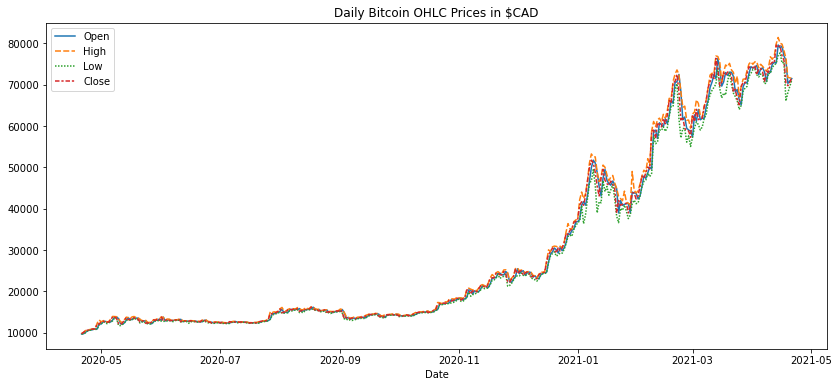

In [22]:
# Import the necessary libraries
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

# Location of the file path
bitcoin_path = os.path.join("C:/Users/lynst/Documents/GitHub/machine-learning-projects/machine-learning/BTC_CAD.csv")

# Open the file into a variable bitcoin
bitcoin = pd.read_csv(bitcoin_path, index_col="Date", parse_dates=True)

# removing the 'Adj close' and 'Volume' columns
del bitcoin['Adj Close']
del bitcoin['Volume']

# Plot the width and height of the figure
plt.figure(figsize=(14,6))

# Add a decsriptive title
plt.title("Daily Bitcoin OHLC Prices in $CAD")

# Line chart showing daily global streams of each song 
sns.lineplot(data=bitcoin)

At first glance I can detect an underlying trend for the price of Bitcoin, but there is also a noticable spike in Feb 2021 before reverting back to the trend. This makes the price data easier to read once the width and height of the axes have been adjusted. If I want to create a subplot of the 'Close' price (as the target variable I will eventually use), then I may decide to list the columns first:

In [23]:
list(bitcoin.columns)

['Open', 'High', 'Low', 'Close']

Text(0.5, 0, 'Date')

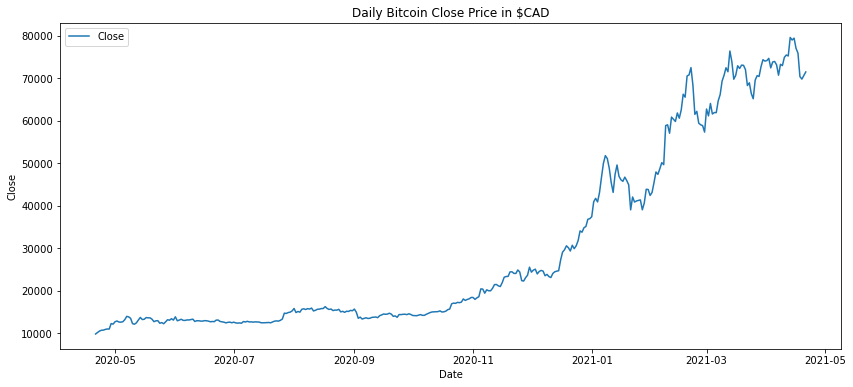

In [24]:
# Once again setting the width and height of the figure
plt.figure(figsize=(14,6))

# Add title
plt.title("Daily Bitcoin Close Price in $CAD")

# Line chart showing daily 'Close'
sns.lineplot(data=bitcoin['Close'], label="Close")

# Add label for horizontal axis
plt.xlabel("Date")

So as we can see there is a definite gradual upward trend. In this particular instance the plot exhibits a price pattern called an 'ascending triangle' which is a term used by technical analysts. This term can be used to make buying and selling decisions based on the shape of the pattern.

## Correlation (Multivariate Stats)
The first stage of any feature selection process for a linear regression model should involve checking multivariate statistics and the degree of correlation between the features and also with the target variable. (Be careful and perform the correlation function on 'bitcoin' dataframe, not the 'data' dictionary. This multivariate statistic is essential to avoid poor performance as high correlations between variables can prevent the model's loss function from converging to the global minimum.

First I need to make sure I re-introduce the 'Volume' attribute so in order to do this I must read the data from the original filepath again taking car to remove the 'Adj Close' column.

In [25]:
# Location of the file path
bitcoin_path = os.path.join("C:/Users/lynst/Documents/GitHub/machine-learning-projects/machine-learning/BTC_CAD.csv")

# Open the file into a variable bitcoin
bitcoin = pd.read_csv(bitcoin_path)

# removing the 'Adj close' column
del bitcoin['Adj Close']

In [26]:
correlation = bitcoin.corr()
print(correlation)

            Open      High       Low     Close    Volume
Open    1.000000  0.999003  0.998283  0.997880  0.584975
High    0.999003  1.000000  0.998194  0.999188  0.592747
Low     0.998283  0.998194  1.000000  0.998735  0.569046
Close   0.997880  0.999188  0.998735  1.000000  0.582709
Volume  0.584975  0.592747  0.569046  0.582709  1.000000


I would expect the opening and closing prices to be defined by the range of the high and low daily prices so all of these values tend to move within a fairly narrow band. There is a strong degree of positive correlation between these time-series values. I can also determine there is a less powerful degree of association between the volume of currency traded and its closing price (0.582709), but a positive relationship nonetheless. 

 Assuming I wanted to find the top three highest correlated features I could use the .abs() and .nlargest() methods:

In [27]:
print(bitcoin.corr().abs().nlargest(3, 'Close').index)          # to find the top 3 features with highest correlation values

Index(['Close', 'High', 'Low'], dtype='object')


In [28]:
print(bitcoin.corr().abs().nlargest(3, 'Close').values[:,3])         # top 3 correlation values

[1.         0.99918803 0.99873489]


Firstly, the perfectly correclated value of 1.0 represents the 'Close' price correlation with itself, but the nest two correlation values of 0.99918803 and 0.99873489 represent those of the daily 'High' and 'Low' resepectively.

Remember, this would only be necessary if I wanted to include only those features with the top 3 correlation scores. For the purpose of this model that would be the open, high and low prices but I want to include the volume also and have decided to keep all 4 features. Next I intend to look at a scatter plot to show the relationship between some of these variables starting with the daily high and close prices.

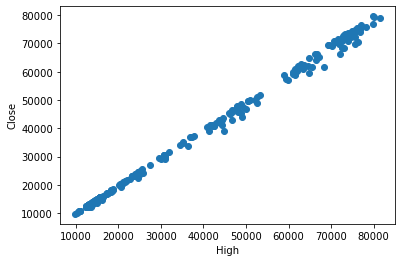

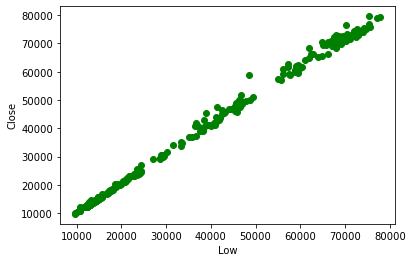

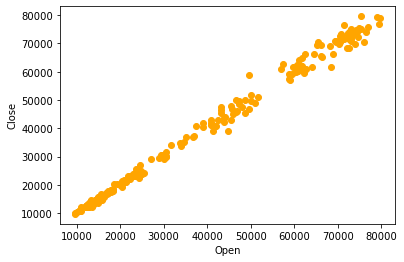

In [29]:
plt.scatter(bitcoin['High'], bitcoin['Close'], marker='o')
plt.xlabel('High')
plt.ylabel('Close')
plt.show()

plt.scatter(bitcoin['Low'], bitcoin['Close'], marker='o', color='green')
plt.xlabel('Low')
plt.ylabel('Close')
plt.show()

plt.scatter(bitcoin['Open'], bitcoin['Close'], marker='o', color='orange')
plt.xlabel('Open')
plt.ylabel('Close')
plt.show()

A strong positive linear relationship exists between the High, Low and Open prices with the Close but the degree of correlation decreases with High, Low and Open prices respectively. Also this can be checked against the 4th row of the correlation matrix under the row with 'Close' in the entry.

And finally the relationship plot of daily volume against the closing prices. I can see there is one outlier on the right hand side.

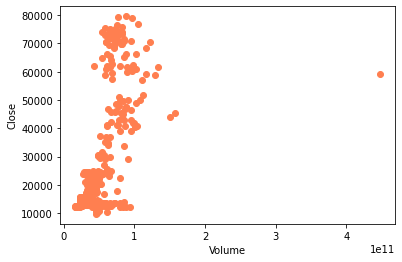

In [30]:
plt.scatter(bitcoin['Volume'], bitcoin['Close'], marker='o', color='coral')
plt.xlabel('Volume')
plt.ylabel('Close')
plt.show()

So there definitely is a relationship between 'Volume' and 'Close' but it doesn't appear to be very linear. It's all confined to a group with an outlier around the C$60,000 mark which represents a spike in contracts traded. Another problem I can see on the plot is the scale of the axis containing the 'Volume' values which indicates the need for feature normalization to address any adverse effects these values might have on the model training process.

## Feature Normalization
I first need to define the values of the numeric columns in the dataset to a common scale using MinMaxScaler(). 

In [31]:
import pandas as pd
from sklearn import preprocessing

# Location of the file path
bitcoin_path = os.path.join("C:/Users/lynst/Documents/GitHub/machine-learning-projects/machine-learning/BTC_CAD.csv")

# Open the file into a variable bitcoin
bitcoin = pd.read_csv(bitcoin_path).dropna(axis=0)

# remove feature with string values - Date
del bitcoin['Date']

# check dataset now
print(bitcoin)

         Open      High       Low     Close  Adj Close        Volume
0     9718.07   9838.33   9728.25   9763.94    9763.94  4.624843e+10
1     9762.68  10125.87   9747.39  10096.28   10096.28  4.716635e+10
2    10102.09  10533.73  10009.76  10451.16   10451.16  6.119120e+10
3    10457.43  10678.71  10457.43  10642.81   10642.81  4.881932e+10
4    10642.22  10773.18  10601.61  10669.64   10669.64  4.643028e+10
..        ...       ...       ...       ...        ...           ...
360  79368.23  79831.47  75262.20  77018.32   77018.32  1.050000e+11
361  76964.70  78268.41  75503.00  75906.36   75906.36  8.272967e+10
362  75928.95  76373.72  66081.83  70374.91   70374.91  1.220000e+11
363  70344.11  71803.61  68107.27  69788.23   69788.23  8.183693e+10
365  71509.30  71556.76  71132.08  71477.76   71477.76  8.495634e+10

[362 rows x 6 columns]


This transformation will shift the values to a range between 0 and 1 for each column. 

In [32]:
# assign bitcoin dataset to df
df = bitcoin.dropna(axis=0)

# convert entries to float type
X = df.values.astype(float)

# define min max scaler
min_max_scaler = preprocessing.MinMaxScaler()

# transform data
X_scaled = min_max_scaler.fit_transform(X)

# 
df = pd.DataFrame(X_scaled, columns=df.columns)
print(df)

         Open      High       Low     Close  Adj Close    Volume
0    0.000000  0.000000  0.000000  0.000000   0.000000  0.068801
1    0.000638  0.004016  0.000281  0.004759   0.004759  0.070934
2    0.005493  0.009711  0.004140  0.009841   0.009841  0.103523
3    0.010577  0.011736  0.010724  0.012585   0.012585  0.074775
4    0.013220  0.013055  0.012844  0.012969   0.012969  0.069224
..        ...       ...       ...       ...        ...       ...
357  0.996343  0.977458  0.963766  0.963054   0.963054  0.205318
358  0.961961  0.955629  0.967307  0.947131   0.947131  0.153570
359  0.947145  0.929170  0.828756  0.867923   0.867923  0.244820
360  0.867254  0.865348  0.858543  0.859522   0.859522  0.151496
361  0.883922  0.861901  0.903027  0.883716   0.883716  0.158744

[362 rows x 6 columns]


## Price Frequency Distributions and Data Dispersion

Taking a look at the frequency distributions of the different prices can tell me about their distributions about the average.

I know that earlier in the timeframe captured there were a large number of cumulative values within the ten to twenty thousand dollar range. The extra weighting given to these observations have obviously caused a fairly low mean value of approximately thirty thousand dollars, but the cryptocurrency finished up at 71.5 thousand dollars by April 2021. The overall range of price values has been divided into 20 separate bins for some clarity, so I can view the frequency or number of daily prices that fall within each interval category price range or bin.

Text(0, 0.5, 'Count')

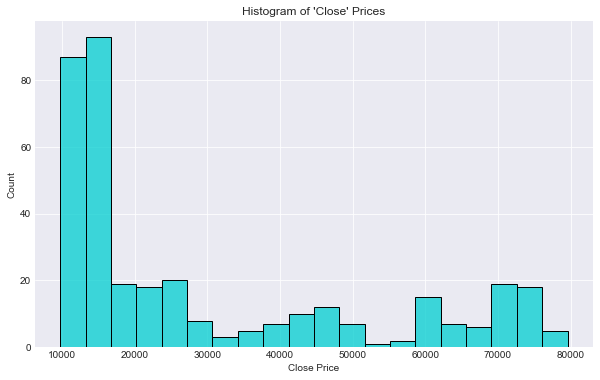

In [33]:
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib import style
import seaborn as sns

# create style
style.use("seaborn-darkgrid")

# set width and height
plt.figure(figsize=(10,6))

# Add a title
plt.title("Histogram of 'Close' Prices")

# Show the average daily closing price
sns.histplot(data=bitcoin, x=bitcoin['Close'], bins=20, color='darkturquoise')

# Add labels for both axes
plt.xlabel('Close Price')
plt.ylabel('Count')

Storing these values in a dataframe series and applying the mean method requires a few steps.

In [34]:
# create filepath for dataset
btc_cad_path = os.path.join("C:/Users/lynst/Documents/GitHub/machine-learning-projects/machine-learning/BTC_CAD.csv")

# create a dict and then store a single column as a dataframe
data = {'Open': bitcoin['Open'],
        'High': bitcoin['High'],
        'Low': bitcoin['Low'],
        'Close': bitcoin['Close']}

df = pd.DataFrame(data, columns = ['Close'])

print(df)
print (type(df))

        Close
0     9763.94
1    10096.28
2    10451.16
3    10642.81
4    10669.64
..        ...
360  77018.32
361  75906.36
362  70374.91
363  69788.23
365  71477.76

[362 rows x 1 columns]
<class 'pandas.core.frame.DataFrame'>


Next, converting the DataFrame column to a Series using the squeeze() method:

In [35]:
close_series = df['Close'].squeeze()

print(close_series)
print (type(close_series))

0       9763.94
1      10096.28
2      10451.16
3      10642.81
4      10669.64
         ...   
360    77018.32
361    75906.36
362    70374.91
363    69788.23
365    71477.76
Name: Close, Length: 362, dtype: float64
<class 'pandas.core.series.Series'>


So, now the 'dataframe' column has been converted to a 'series' data type, I aim to find the mean of the values for 'Close' prices over the period in question and display their frequency distribution.

29864.750828729273


C:\Users\lynst\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


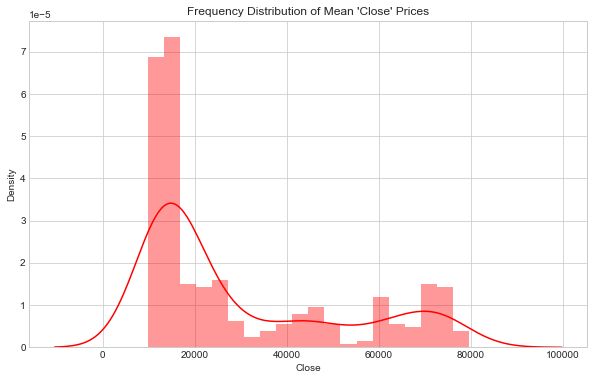

In [36]:
# create style
style.use("seaborn-whitegrid")

# print the mean value
print(close_series.mean())

# configure the plot size
plt.figure(figsize=(10,6))

# create a title
plt.title("Frequency Distribution of Mean 'Close' Prices")

# plot the series
close_plot = sns.distplot(close_series, bins=20, color='red')

The mean value is to the right of the peak on the frequency curve with a long tail containing values toward C$90,000 which exhibits positive skewness. 

The frequency distribution plots for the open, high, low and daily volume not only explain the range of values and the dispersion about the mean, but they also be some indication of how prices might revert back to some long term average. It would be foolish to assume that Bitcoin prices will continue the current upward trend beyond C$80,000 because the average is so low.

Text(0, 0.5, 'Count')

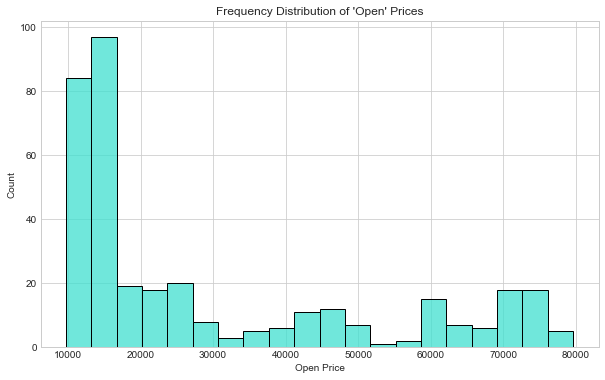

In [37]:
# create style
style.use("seaborn-whitegrid")

# set width and height
plt.figure(figsize=(10,6))

# Add a title
plt.title("Frequency Distribution of 'Open' Prices")

# Show the average daily high price
sns.histplot(data=bitcoin, x=bitcoin['Open'], bins=20, color='turquoise')

# Add labels for both axes
plt.xlabel('Open Price')
plt.ylabel('Count')

Text(0, 0.5, 'Count')

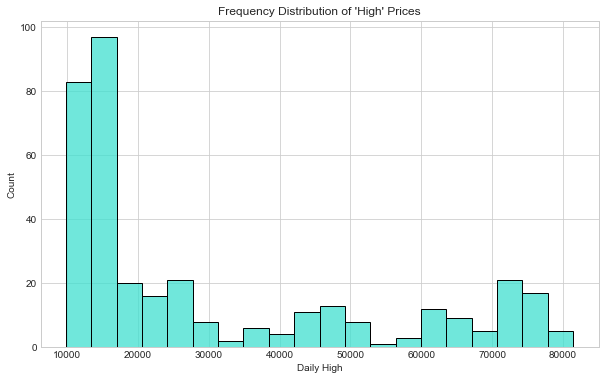

In [38]:
# create style
style.use("seaborn-whitegrid")

# set width and height
plt.figure(figsize=(10,6))

# Add a title
plt.title("Frequency Distribution of 'High' Prices")

# Show the average daily high price
sns.histplot(data=bitcoin, x=bitcoin['High'], bins=20, color='turquoise')

# Add labels for both axes
plt.xlabel('Daily High')
plt.ylabel('Count')

Text(0, 0.5, 'Count')

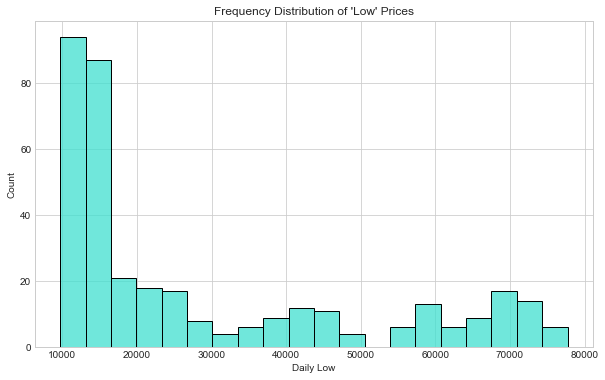

In [39]:
# create style
style.use("seaborn-whitegrid")

# set width and height
plt.figure(figsize=(10,6))

# Add a title
plt.title("Frequency Distribution of 'Low' Prices")

# Show the average daily low price
sns.histplot(data=bitcoin, x=bitcoin['Low'], bins=20, color='turquoise')

# Add labels for both axes
plt.xlabel('Daily Low')
plt.ylabel('Count')

Text(0, 0.5, 'Count')

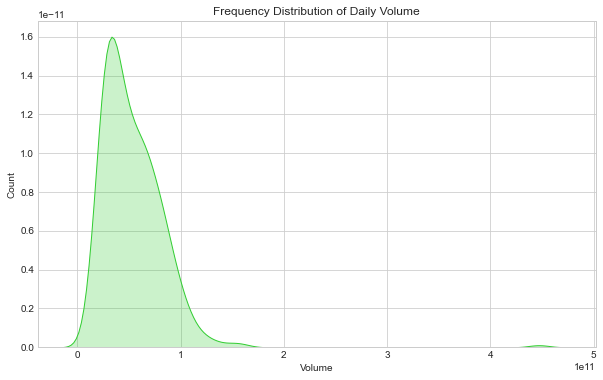

In [40]:
# create style
style.use("seaborn-whitegrid")

# set width and height
plt.figure(figsize=(10,6))

# Add a title
plt.title("Frequency Distribution of Daily Volume")

# Show the average daily volume
#sns.histplot(data=bitcoin, x=bitcoin['Volume'], bins=20, color='limegreen')
sns.kdeplot(data=bitcoin, x=bitcoin['Volume'], color='limegreen', shade=True)

# Add labels for both axes
plt.xlabel('Volume')
plt.ylabel('Count')

The bulk of the daily volume of transactions rarely exceeds 100 billion but there are a few exceptions. 

Given the mean values for OHLC prices, another way to find out how many values are above or below the average would be:

In [41]:
bitcoin['Open'].loc[bitcoin['Open'] > 29707.22]

243    30515.50
244    30072.23
246    30661.51
247    29849.93
248    30526.47
         ...   
360    79368.23
361    76964.70
362    75928.95
363    70344.11
365    71509.30
Name: Open, Length: 121, dtype: float64

In [42]:
tot_o = (121 / 162) * 100
print(tot_o)

74.69135802469135


In [43]:
bitcoin['High'].loc[bitcoin['High'] > 30555.68]

242    30802.08
243    30972.39
244    30908.42
245    30671.73
246    30946.14
         ...   
360    79831.47
361    78268.41
362    76373.72
363    71803.61
365    71556.76
Name: High, Length: 123, dtype: float64

So there are 121 values greater than the mean daily opening price. Calculating this as a percentage of the total number of observations gives:

In [44]:
tot_h = (123 / 162) * 100
print(tot_h)

75.92592592592592


Repeating this step for the other price attributes gives:

In [45]:
bitcoin['Low'].loc[bitcoin['Low'] > 28874.21]

242    29191.52
243    29602.33
245    28883.40
246    29302.54
247    29249.96
         ...   
360    75262.20
361    75503.00
362    66081.83
363    68107.27
365    71132.08
Name: Low, Length: 122, dtype: float64

In [46]:
tot_l = (122 / 162) * 100
print(tot_l)

75.30864197530865


In [47]:
bitcoin['Close'].loc[bitcoin['Close'] > 29864.75]

242    30525.81
243    30075.87
245    30662.86
247    30529.54
248    31754.68
         ...   
360    77018.32
361    75906.36
362    70374.91
363    69788.23
365    71477.76
Name: Close, Length: 121, dtype: float64

In [48]:
tot_c = (121 / 162) * 100
print(tot_c)

74.69135802469135


I can tell for all of these price categories that roughly 75% of the values lie above the mean which is another way to show their frequency distributions are positively skewed.

# Feature Selection
Choosing the right data columns (features) for the Input set:

In [49]:
# import libraries
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

# import data
bitcoin = pd.read_csv("C:/Users/lynst/Documents/GitHub/machine-learning-projects/machine-learning/BTC_CAD.csv")
df = pd.DataFrame(bitcoin).dropna(axis=0)

Checking the data in the first couple of rows:

In [50]:
df.head(2)

,Date,Open,High,Low,Close,Adj Close,Volume
0,2020-04-21,9718.07,9838.33,9728.25,9763.94,9763.94,4.624843e+10
1,2020-04-22,9762.68,10125.87,9747.39,10096.28,10096.28,4.716635e+10


In [51]:
print(df)

           Date      Open      High       Low     Close  Adj Close  \
0    2020-04-21   9718.07   9838.33   9728.25   9763.94    9763.94   
1    2020-04-22   9762.68  10125.87   9747.39  10096.28   10096.28   
2    2020-04-23  10102.09  10533.73  10009.76  10451.16   10451.16   
3    2020-04-24  10457.43  10678.71  10457.43  10642.81   10642.81   
4    2020-04-25  10642.22  10773.18  10601.61  10669.64   10669.64   
..          ...       ...       ...       ...       ...        ...   
360  2021-04-16  79368.23  79831.47  75262.20  77018.32   77018.32   
361  2021-04-17  76964.70  78268.41  75503.00  75906.36   75906.36   
362  2021-04-18  75928.95  76373.72  66081.83  70374.91   70374.91   
363  2021-04-19  70344.11  71803.61  68107.27  69788.23   69788.23   
365  2021-04-21  71509.30  71556.76  71132.08  71477.76   71477.76   

           Volume  
0    4.624843e+10  
1    4.716635e+10  
2    6.119120e+10  
3    4.881932e+10  
4    4.643028e+10  
..            ...  
360  1.050000e+11  

In [52]:
# all column names
df.columns

Index(['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'], dtype='object')

In [53]:
# all column data types
df.dtypes

Date          object
Open         float64
High         float64
Low          float64
Close        float64
Adj Close    float64
Volume       float64
dtype: object

Next I want to split the data into predictors and a target variable, containing all my feature columns in one matrix or Input variable (X) and the Target or Output variable in a column vector (y). Assigning the dependant, or y variable for the modelling process to the daily close price information (which will represent the labelled data), I have:

In [54]:
y = df['Close']
print(y)

0       9763.94
1      10096.28
2      10451.16
3      10642.81
4      10669.64
         ...   
360    77018.32
361    75906.36
362    70374.91
363    69788.23
365    71477.76
Name: Close, Length: 362, dtype: float64


The features are a selection of columns used to predict 'y', also known as the independent variables. I am choosing to leave the 'Date' and 'Adj Close' columns out of this dataframe.

Note, I can either store the individual features in a variable which can be referenced or called when performing some function, or I can store the exact feature names as a list in the dataframe. For example:

In [55]:
bitcoin_features = ['Open','High','Low','Volume']
print(bitcoin_features)

['Open', 'High', 'Low', 'Volume']


In [56]:
# select features
X = df[bitcoin_features]
print(X)

         Open      High       Low        Volume
0     9718.07   9838.33   9728.25  4.624843e+10
1     9762.68  10125.87   9747.39  4.716635e+10
2    10102.09  10533.73  10009.76  6.119120e+10
3    10457.43  10678.71  10457.43  4.881932e+10
4    10642.22  10773.18  10601.61  4.643028e+10
..        ...       ...       ...           ...
360  79368.23  79831.47  75262.20  1.050000e+11
361  76964.70  78268.41  75503.00  8.272967e+10
362  75928.95  76373.72  66081.83  1.220000e+11
363  70344.11  71803.61  68107.27  8.183693e+10
365  71509.30  71556.76  71132.08  8.495634e+10

[362 rows x 4 columns]


In [57]:
# an alternative way
X = df[["Open", "High", "Low", "Volume"]]
print(X)

         Open      High       Low        Volume
0     9718.07   9838.33   9728.25  4.624843e+10
1     9762.68  10125.87   9747.39  4.716635e+10
2    10102.09  10533.73  10009.76  6.119120e+10
3    10457.43  10678.71  10457.43  4.881932e+10
4    10642.22  10773.18  10601.61  4.643028e+10
..        ...       ...       ...           ...
360  79368.23  79831.47  75262.20  1.050000e+11
361  76964.70  78268.41  75503.00  8.272967e+10
362  75928.95  76373.72  66081.83  1.220000e+11
363  70344.11  71803.61  68107.27  8.183693e+10
365  71509.30  71556.76  71132.08  8.495634e+10

[362 rows x 4 columns]


A couple of important things to note here. Firstly because I already dropped not-available row entries (3), there are 362 correct entries spanning 365 rows which is correct. I don't need to perform this dropna() method on X and y individually because I have already applied this operation to the dataframe (df).

Secondly, I can see that referencing the features and storing them in a separate variable named 'bitcoin_features' really only comes in handy when there are a large number of features, perhaps too many to type into a list; but for the purpose of this exercise I prefer entering each feature name individually.

## Splitting the Data
Split the data into training and test sets with a 70-30 split but not without making a copy of the dataframe first.

In [58]:
df = df.copy()

In [59]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

Printing out the shape of the training sets for both the X matrix and y vector gives:

In [60]:
print(X_train.shape)
print(y_train.shape)

(253, 4)
(253,)


And the shape of the test data:

In [61]:
print(X_test.shape)
print(y_test.shape)

(109, 4)
(109,)


So I can see that 253/362 * 100 = 70% and 109/362 * 100 = 30% for both the train and test sets respectively. Next I will save a copy of the dataframe to use.

# Model Selection (Linear Regression)
This enables me to explore the linear nature of the relationship between the input and output data and fit a regression line using a scatter plot.

## Training the Data and Fitting

In [62]:
# instantiate model
linear_regression = LinearRegression()

# fit model
linear_regression.fit(X_train, y_train)

LinearRegression()

Now the 'training' data has been fit, try making a prediction on the first 4 values in the test set first. This includes all the values in row one of X.

In [63]:
price_predictions = linear_regression.predict(X_test)
print("Predictions: ", linear_regression.predict(X_test.iloc[:4]))

Predictions:  [14235.0672502  12655.46154078 13223.19509735 70402.98731737]


Comparing these values to the actual test set values:

In [64]:
X_test.head(1)

,Open,High,Low,Volume
163,14354.31,14506.5,13948.08,3.611139e+10


In [65]:
# I want to predict the close price based on the values from line 163 in the table above
linear_regression.predict([[14354.31, 14506.5, 13948.08, 3.611139e+10]])

array([14235.06724902])

Comparing this forecast value for y to the actual value for y:

In [66]:
y_actual = 14115.09

# Assuming y = a + b1x1 + b2x2 + b3x3 + b4x4
# where:
# a = intercept (bias term)
# b = coefficient value
# x = feature value

y = 107.8575212006981 + (-4.38810208e-01*14354.31) + (9.50132416e-01*14506.5) + (4.76889709e-01*13948.08) + (-2.42699860e-10*3.611139e+10)

print(y)

14235.067240119533


So I can see that C$ 14,115.09 is reasonably close to the predicted value for y, but not that great! The Linear Regression prediction value is almost identical to my prediction model for y so I know the formula works.

## Metrics
So checking the values against the BTC_CAD.csv dataset I can see they are not exactly accurate. One way to check is introduce an accuracy score called MSE (mean squared error), but first I will check the R-squared measure to establish the overall degree of fit to the line.

In [67]:
print("R-squared: ", linear_regression.score(X_test, y_test))

R-squared:  0.9991392014437468


This is a fairly high score and I can see this relationship in a scatter plot showing actual prices against predicted prices.

474986.3845723801
689.1925598643533


<AxesSubplot:title={'center':'Actual Prices vs Predicted Prices'}, xlabel='Close', ylabel='Predicted Prices'>

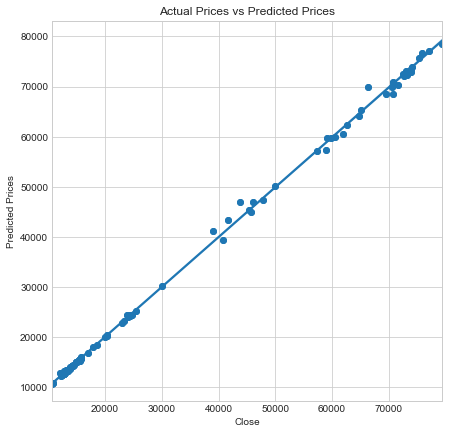

In [68]:
from sklearn.metrics import mean_squared_error
import numpy as np

mse = mean_squared_error(y_test, price_predictions)
print(mse)

rmse = np.sqrt(mse)
print(rmse)

# set the width and height of the plot
plt.figure(figsize=(7,7))

# visualizing the relationship between actual and predicted values for y
plt.scatter(y_test, price_predictions)
plt.xlabel("Actual Prices")
plt.ylabel("Predicted Prices")
plt.title("Actual Prices vs Predicted Prices")

# fit a regression line between high and low values to show linear nature
sns.regplot(x=y_test, y=price_predictions)

To find the intercept and coefficients:

In [69]:
print(linear_regression.intercept_)
print(linear_regression.coef_)

107.8575212006981
[-4.38810208e-01  9.50132416e-01  4.76889709e-01 -2.42699860e-10]


This output provides me with the intercept value which intersects the y-axis at 107.85 and the respective coefficient values for each independent variable from x1 to x4 (open, high, low and volume values).

# Evaluation
My first look at the results of the scores and their accuracy measures prompted me to re-visit the code and try and introduce more efficiency (reducing the number of lines), but also more consistency such as replicating similar steps for the use of different types of model. So even though I started storing the same dataset in different variables it can quickly become confusing and simultaneously very important to ensure some similarity exists with regard to training, testing and evaluation/performance measurement among the different models. 

These procedures will require more modification when I start to apply Polynomial Regression and tackle any problems attributed to over or under-fitting of data with the application of regularization.

Initial linear regression rmse score = 689.1925598643533
R-squared accuracy = 0.9991392014437468

In conclusion, the model requires a much larger dataset and would benefit from a larger time period of price information, perhaps dating back to it's initial inception (2010 - not that long ago). Because the dataset is too small it falls prey to 'Sampling Noise' which is the degree of error from sampling only one subsection of the population. The model could be improved if other sample sizes were used or if the entire population of data for Bitcoin prices was used. 

Regularization implies reducing the number of features or creating a more efficient use of feature engineering to counteract overfitting the data and should be applied to improve this problem. As well as more price data another way to achieve better generalization on unseen data may involve using features from substitute investments or alternative crypto-currencies. It might pay to include market indices relevant to the sector, or even some form of sentiment analysis from market news which could be interpreted numerically using a form of one-hot encoding. 

This model could potentially incorporate the risk from substitute investments (Dogecoin for example) which are direct competitors or alternative investments (such as Gold) which are a vital component of several investment portfolios, the risk associated with the industry or market sector, political risk associated with foreign and domestic policy, or even corporate risk associated with management level decisions such as whether or not Blockchain technology could be under threat of being potentially unravelled by Quantum computing. 

All of these components combined would no doubt provide a better overall picture and contribute to more accurate price discovery in the Crypto markets. Next, I will try to fit a forecast line using a Polynomial Regression model but for now let's print out dependencies which allow this notebook to be reproducable across different platforms so others who are interested can view these findings.

# Print dependencies
Dependencies are fundamental to record the **computational environment**.   

- Use [watermark](https://github.com/rasbt/watermark) to print version of python, ipython, and packages, and characteristics of the computer

In [70]:
%load_ext watermark

# python, ipython, packages, and machine characteristics
%watermark -v -m -p wget,pandas,numpy,watermark,tarfile,urllib3,matplotlib,seaborn,sklearn,pickle5 

# date
print (" ")
%watermark -u -n -t -z 

Python implementation: CPython
Python version       : 3.8.10
IPython version      : 7.22.0

wget      : 3.2
pandas    : 1.2.4
numpy     : 1.19.2
watermark : 2.2.0
tarfile   : 0.9.0
urllib3   : 1.26.6
matplotlib: 3.3.4
seaborn   : 0.11.1
sklearn   : 0.24.2
pickle5   : not installed

Compiler    : MSC v.1916 64 bit (AMD64)
OS          : Windows
Release     : 10
Machine     : AMD64
Processor   : Intel64 Family 6 Model 158 Stepping 10, GenuineIntel
CPU cores   : 8
Architecture: 64bit

 
Last updated: Wed Jun 30 2021 21:54:45Eastern Daylight Time

